<a href="https://colab.research.google.com/github/Sopralapanca/CommonLitChallenge/blob/main/Correction%2BPOS%2BNER%2BPrepareDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data importing and setup

In [25]:
!pip install spacy pyspellchecker symspellpy swifter

In [26]:
 !pip install --no-cache-dir transformers

In [27]:
!python -m spacy download en_core_web_sm

2023-10-02 12:26:34.636429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [28]:
!git clone "https://github.com/Sopralapanca/CommonLitChallenge.git"

fatal: destination path 'CommonLitChallenge' already exists and is not an empty directory.


In [29]:
import pandas as pd
import swifter
import numpy as np
summaries_train_path = "/content/CommonLitChallenge/data/summaries_train.csv"
prompt_train_path = "/content/CommonLitChallenge/data/prompts_train.csv"

train_data = pd.read_csv(summaries_train_path, sep=',', index_col=0)
prompt_data = pd.read_csv(prompt_train_path, sep=',', index_col=0)

### Tokenization length

In [64]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

train_data['tokenized_text'] = train_data.swifter.apply(lambda x: tokenizer.tokenize(x.text), axis=1)
train_data['tokenized_text_len'] = train_data.swifter.apply(lambda x: len(x.tokenized_text), axis=1)
train_data.drop(columns=['tokenized_text'], inplace=True)

prompt_data['tokenized_prompt_text'] = prompt_data.swifter.apply(lambda x: tokenizer.tokenize(x.prompt_text), axis=1)
prompt_data['tokenized_prompt_text_len'] = prompt_data.swifter.apply(lambda x: len(x.tokenized_prompt_text), axis=1)
prompt_data.drop(columns=['tokenized_prompt_text'], inplace=True)

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

### Spacy and SymSpell Magic Class

> Creation of the word list \\
> Language Model Class construction

#### Creating the list of words

In [30]:
import itertools
word_list = []
for prompt, query, title in zip(prompt_data.prompt_text.tolist(), prompt_data.prompt_question.tolist(), prompt_data.prompt_title.tolist()):
  word_list.append(prompt.replace('\n', ' ').split())
  word_list.append(query.replace('\n', ' ').split())
  word_list.append(title.replace('\n', ' ').split())
token_list = list(itertools.chain(*word_list))

#### Construction of the Class


In [31]:
from symspellpy import SymSpell
import pkg_resources
import spacy

class LanguageMagician():
  def __init__(self, words) -> None:
    # Initialization of Spacy
    self.nlp = spacy.load("en_core_web_sm")

    # Initialization of SymSpell
    self.sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt"
    )
    bigram_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
    )
    # term_index is the column of the term and count_index
    # is the column of the term frequency
    self.sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    self.sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
    # Spacy vocabulary initialization
    vector_data = {word: np.random.uniform(-1, 1, (300,)) for word in words}
    vocab = self.nlp.vocab
    for word, vector in vector_data.items():
        vocab.set_vector(word, vector)

    # SymSpell vocabulary initialization
    text_file = open("vocabulary.txt", "a")
    for s in words:
      text_file.write(s)
    text_file.close()
    corpus_path = 'vocabulary.txt'
    try:
      result = self.sym_spell.create_dictionary(corpus_path)
    except:
      raise(f'error the dictionary creation has returned {result}')

  def correct(self, row):
    # max edit distance per lookup (per single word, not per whole input string)
    try:
      suggestions = self.sym_spell.lookup_compound(row, max_edit_distance=2, transfer_casing=True)
      return suggestions[0].term, suggestions[0].distance
    except:
      suggestions = self.sym_spell.lookup_compound(row, max_edit_distance=2, transfer_casing=False)
      return suggestions[0].term, suggestions[0].distance

  def entity__pos_scorer(self, row):
    doc = self.nlp(row)
    ent_score = 0
    for e in doc.ents:
        ent_score += 1
    pos_score = 0
    for d in doc:
        pos_score += 1
    return ent_score, pos_score

  # def semantic_similarity(self, text1, text2):
  #   embedding1 = self.nlp(text1)
  #   embedding2 = self.nlp(text2)
  #   return embedding1.similarity(embedding2)

lang_wizard = LanguageMagician(token_list)

### Text processing

In [92]:
import re
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocessText(text, removal=True):
    # replace newline with space
    text = text.replace("\n", " ")
    text = text.replace('\r', ' ')

    # Normalize spaces around punctuation marks
    text = re.sub(r"[^A-Za-z0-9']", r' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Replace curly apostrophe with straight single quote
    text = text.replace('’', "'")

    # Normalize spaces around punctuation marks
    text = text.strip()

    # lower case
    text = text.lower()

    if removal:
      # split text
      words = text.split()

      # stop word removal
      words = [w for w in words if not w in stop_words]

      # stemming
      # words = [stemmer.stem(w) for w in words]

      # lemmatization
      words = [lemmatizer.lemmatize(w) for w in words]

      text = ' '.join(words)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### StopWords Count

In [33]:
# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stop_words)
    return stopwords_count

### Punctuation Count

In [97]:
# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

### Different Words counter

In [35]:
def different_word_counter(row):
  row = preprocessText(row)
  words_list = []
  for w in row.split(' '):
    if w not in words_list:
      words_list.append(w)

  return len(words_list)

### Words counter

In [36]:
def count_words(text):
    return len(text.split(' '))

### N-grams finding

In [37]:
from nltk.util import ngrams
from collections import Counter
import nltk
nltk.download('punkt')  # Download the required resources for tokenization

def count_ngrams(text, n):
  words = nltk.word_tokenize(text)
  ngram_counts = Counter(ngrams(words, n))
  return ngram_counts

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Dataset Application before merging


In [38]:
del_columns = []
# Correct the text
train_data[["corrected_text", "distance"]] = train_data.swifter.apply(lambda x: lang_wizard.correct(x.text), axis=1, result_type='expand')
# Preprocess the text
prompt_data["prompt_preprocessed"] =           prompt_data["prompt_text"].swifter.apply(lambda x: preprocessText(x))
train_data["corrected_text_preprocessed"] =    train_data["corrected_text"].swifter.apply(lambda x: preprocessText(x))
train_data["text_preprocessed"] =              train_data["text"].swifter.apply(lambda x: preprocessText(x))
# Count the length of text
prompt_data["prompt_length"] = prompt_data["prompt_text"].swifter.apply(count_stopwords)
train_data["text_length"] =    train_data["corrected_text"].swifter.apply(len)
del_columns.extend(["prompt_length", "text_length"])
# Stop-words count
train_data["stop_cnt"] =        train_data["corrected_text"].swifter.apply(lambda x: count_stopwords(x))
# Punctuation count
train_data["punctuation_cnt"] = train_data["corrected_text"].swifter.apply(lambda x: count_punctuation(x))
# N-Grams counting
for n in range(2,5):
  prompt_data[f"{n}grams_prompt_cnt"] = prompt_data.swifter.apply(lambda row: count_ngrams(row["prompt_preprocessed"], n), axis=1)
  del_columns.append(f"{n}grams_prompt_cnt")

  train_data[f"{n}grams_corrected_cnt"] = train_data.swifter.apply(lambda row: count_ngrams(row["corrected_text_preprocessed"], n), axis=1)
  del_columns.append(f"{n}grams_corrected_cnt")

  train_data[f"{n}grams_text_cnt"] = train_data.swifter.apply(lambda row: count_ngrams(row["text_preprocessed"], n), axis=1)
  del_columns.append(f"{n}grams_text_cnt")
# POS & Entity vectorization
train_data[["entities", "text_pos"]] = train_data.swifter.apply(lambda x: lang_wizard.entity__pos_scorer(x.corrected_text), axis=1, result_type='expand')
# Different Word Counter
prompt_data["prompt_different_word_cnt"] = prompt_data['prompt_text'].swifter.apply(lambda row: different_word_counter(row))
train_data['text_different_word_cnt'] = train_data['corrected_text'].swifter.apply(lambda row: different_word_counter(row))
del_columns.extend(["prompt_different_word_cnt", "text_different_word_cnt"])

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:01<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

In [65]:
# @title Merging the dataset
training_data = train_data.merge(prompt_data, on='prompt_id')

### Different words counter ratio

In [66]:
def word_counter_ratio(summary_word_counter, prompt_word_counter):
  return summary_word_counter/prompt_word_counter

### N-grams counting

In [67]:
def count_cooccurring_ngrams(text, prompt_text):
    cooccurring_count = sum(max(text[x], prompt_text[y]) for x, y in zip(text.keys(), prompt_text.keys()) if x == y)
    return cooccurring_count

### Misspelling finding and counting

In [68]:
from spellchecker import SpellChecker

spell = SpellChecker()
spell.word_frequency.load_words(token_list)

def misspelled(text):
  words = text.split()
  misspelled = spell.unknown(words)
  return len(misspelled)

### TF-IDF score creation

In [69]:
def add_row(df1, df2, preprocess=False):
  row = df2.unique().tolist()[0]
  if preprocess:
    row = preprocessText(row)
  combined_data = pd.concat([pd.Series([row]),df1.loc[:]]).reset_index(drop=True) #append row on the head of the dataframe
  return combined_data

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Group by 'prompt_id' and compute TF-IDF separately for each class
tfidf_vectorizers = {}

for class_id, group in training_data.groupby('prompt_id'):
    text_data = group['corrected_text_preprocessed']
    prompt_question_data = group['prompt_question']
    prompt_title_data = group['prompt_title']
    prompt_text_data = group['prompt_preprocessed']

    # Concatenate the preprocessed data for TF-IDF calculation
    combined_data = add_row(text_data, prompt_question_data, True)
    combined_data = add_row(combined_data, prompt_title_data, True)
    combined_data = add_row(combined_data, prompt_text_data)

    # Compute TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_data)
    tfidf_vectorizers[class_id] = {'vectorizer': tfidf_vectorizer, 'matrix': tfidf_matrix}

In [71]:
karp_tfidf_scores = {}

# Calculate TF-IDF scores for each document
for class_id, group in training_data.groupby('prompt_id'):
    tfidf_vectorizer = tfidf_vectorizers[class_id]['vectorizer']
    tfidf_matrix = tfidf_vectorizers[class_id]['matrix']
    tfidf_matrix = tfidf_matrix[3:] #remove first 3 rows f the matrix since they belongs to prompt_text, prompt_question, prompt_title


    # Iterate through documents and calculate TF-IDF scores
    for index, row in group.iterrows():
        doc_tfidf = tfidf_matrix[index - group.index[0]].toarray()[0]

        doc_tfidf = doc_tfidf[doc_tfidf>0]

        single_tfidf_score = sum([t for i, t in enumerate(doc_tfidf)])

        karp_tfidf_scores[index] = single_tfidf_score

## Merged Dataset Application

In [72]:
# Different word count ratio
training_data['different_word_cnt_ratio'] = training_data.swifter.apply(lambda row: word_counter_ratio(row["text_different_word_cnt"], row["prompt_different_word_cnt"]), axis=1)
# N-Grams Copccurrences Counting
for n in range(2, 5):
  prompt_col = f"{n}grams_prompt_cnt"
  corre_col = f"{n}grams_corrected_cnt"
  text_col = f"{n}grams_text_cnt"

  training_data[f"{n}grams_correct_cnt"] = training_data.swifter.apply(lambda row: count_cooccurring_ngrams(row[text_col], row[corre_col]), axis=1)
  training_data[f"{n}grams_cooccurrence_cnt"] = training_data.swifter.apply(lambda row: count_cooccurring_ngrams(row[corre_col], row[prompt_col]), axis=1)
# Semantic Similarity
# training_data["semantic_similarity"] = training_data.swifter.apply(lambda row: lang_wizard.semantic_similarity(row["corrected_text"], row["prompt_text"]), axis=1)
# Mispelled Words Counting
training_data["misspelled_text_cnt"] = training_data["text"].swifter.apply(lambda x: misspelled(x))
# Text Length Ratio
training_data["length_ratio"] = training_data["text_length"] / training_data["prompt_length"]
# TF-IDF scores
training_data['tfidf_scores'] = [karp_tfidf_scores[index] for index in training_data.index]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

## Dataset normalization
Normalize the data taking into consideration the prompt title

In [73]:
training_data.describe()

,content,wording,distance,text_length,stop_cnt,punctuation_cnt,entities,text_pos,text_different_word_cnt,tokenized_text_len,...,different_word_cnt_ratio,2grams_correct_cnt,2grams_cooccurrence_cnt,3grams_correct_cnt,3grams_cooccurrence_cnt,4grams_correct_cnt,4grams_cooccurrence_cnt,misspelled_text_cnt,length_ratio,tfidf_scores
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,...,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,16.576274,408.624145,38.040335,0.160502,1.702163,75.556734,29.645918,93.229170,...,0.130132,22.288625,0.115841,20.629170,0.072017,19.056525,0.053315,6.142219,1.330522,4.764696
std,1.043569,1.036048,20.701110,299.276040,27.201636,0.509187,1.940431,54.037893,18.401862,68.764623,...,0.080591,18.429833,0.934620,18.224489,0.764296,17.859946,0.647509,5.375567,1.117644,1.357693
min,-1.729859,-1.962614,0.000000,112.000000,5.000000,0.000000,0.000000,25.000000,6.000000,26.000000,...,0.027586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.220039,2.088641
25%,-0.799545,-0.872720,6.000000,211.000000,20.000000,0.000000,0.000000,40.000000,17.000000,48.000000,...,0.075862,11.000000,0.000000,9.000000,0.000000,8.000000,0.000000,3.000000,0.645902,3.760674
50%,-0.093814,-0.081769,11.000000,312.000000,29.000000,0.000000,1.000000,58.000000,24.000000,71.000000,...,0.108247,18.000000,0.000000,16.000000,0.000000,15.000000,0.000000,5.000000,0.986885,4.492786
75%,0.499660,0.503833,20.000000,501.000000,47.000000,0.000000,2.000000,93.000000,36.000000,114.000000,...,0.158621,29.000000,0.000000,27.000000,0.000000,25.000000,0.000000,8.000000,1.603376,5.492710
max,3.900326,4.310693,532.000000,3834.000000,327.000000,12.000000,17.000000,663.000000,204.000000,865.000000,...,1.046392,251.000000,27.000000,245.000000,25.000000,239.000000,23.000000,86.000000,16.177215,12.999974


In [74]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def normalize_col(df, col):
    # Create a Min-Max Scaler
    scaler = MinMaxScaler()
    df[col] = df.groupby('prompt_id')[col].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

    return df

In [75]:
normalize_cols = ["misspelled_text_cnt", "tfidf_scores", "text_pos",
                  "entities", "distance", "stop_cnt", "punctuation_cnt"]
for n in range(2, 5):
  normalize_cols.append(f"{n}grams_correct_cnt")
  normalize_cols.append(f"{n}grams_cooccurrence_cnt")
for col in normalize_cols:
  training_data = normalize_col(training_data, col)

In [76]:
# Dropping useless columns
training_data.drop(columns=del_columns, axis=1, inplace=True)

# Dataset analysis

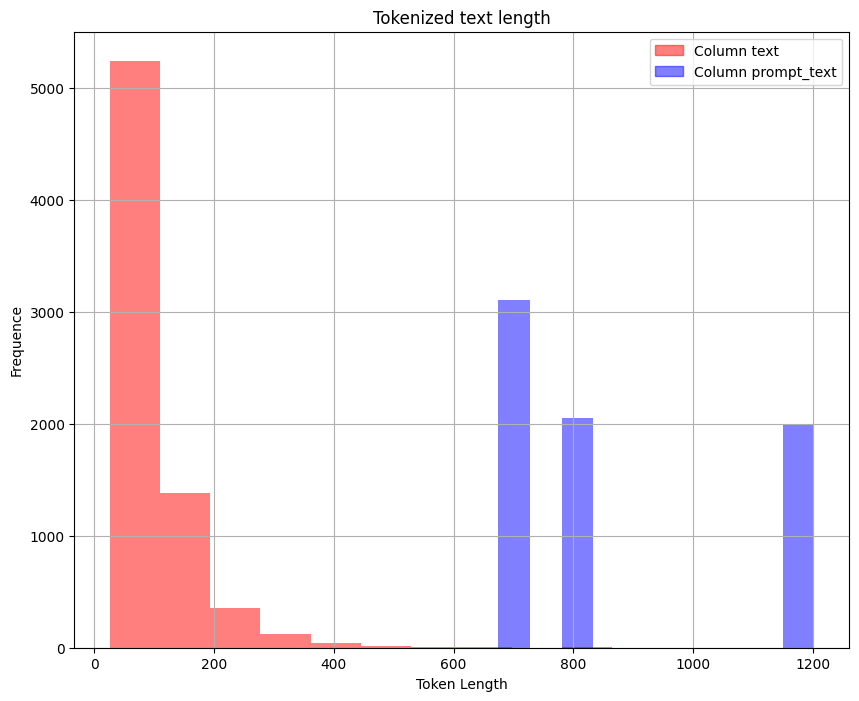

In [78]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))

training_data.hist(column='tokenized_text_len', ax=ax, alpha=0.5, color='red')
training_data.hist(column='tokenized_prompt_text_len', ax=ax, alpha=0.5, color='blue')
ax.set_title('Tokenized text length')
ax.set_xlabel('Token Length')
ax.set_ylabel('Frequence')
red_patch = mpatches.Patch(alpha=0.5, color='red', label='Column text')
blue_patch = mpatches.Patch(alpha=0.5, color='blue', label='Column prompt_text')
plt.legend(handles=[red_patch, blue_patch])

training_data = normalize_col(training_data, "tokenized_text_len")
training_data.drop(columns='tokenized_prompt_text_len', inplace=True)

In [79]:
training_data.head()

,prompt_id,text,content,wording,corrected_text,distance,corrected_text_preprocessed,text_preprocessed,stop_cnt,punctuation_cnt,...,different_word_cnt_ratio,2grams_correct_cnt,2grams_cooccurrence_cnt,3grams_correct_cnt,3grams_cooccurrence_cnt,4grams_correct_cnt,4grams_cooccurrence_cnt,misspelled_text_cnt,length_ratio,tfidf_scores
0,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,The third wave was an experiment to see how pe...,0.045455,third wave experiment see people reacted new o...,third wave experimentto see people reacted new...,0.097297,0.00,...,0.146341,0.166667,0.0,0.155172,0.0,0.147826,0.0,0.081081,1.214789,0.328820
1,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,The Third Wave developed rapidly because the s...,0.553030,third wave developed rapidly student genuinely...,third wave developed rapidly student genuinly ...,0.502703,0.25,...,0.390244,0.175000,0.0,0.129310,0.0,0.104348,0.0,0.729730,4.218310,0.709194
2,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,The third wave only started as an experiment w...,0.083333,third wave started experiment within class slo...,third wave started experiment within class slo...,0.091892,0.50,...,0.131707,0.258333,0.0,0.250000,0.0,0.234783,0.0,0.081081,1.197183,0.298847
3,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,The experiment was originally about how even w...,0.136364,experiment originally even terrible thing happ...,experimen orginally even terrible thngs happen...,0.151351,0.00,...,0.146341,0.091667,0.0,0.241379,0.0,0.226087,0.0,0.297297,1.563380,0.348154
4,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,The third wave developed so quickly due to the...,0.037879,third wave developed quickly due student parti...,third wave developed quickly due student parti...,0.016216,0.00,...,0.063415,0.041667,0.0,0.034483,0.0,0.026087,0.0,0.054054,0.507042,0.090363


In [89]:
training_data.punctuation_cnt.head(100)

0     0.00
1     0.25
2     0.50
3     0.00
4     0.00
      ... 
95    0.00
96    0.00
97    0.00
98    0.00
99    0.00
Name: punctuation_cnt, Length: 100, dtype: float64

In [100]:
training_data.describe()

,content,wording,distance,stop_cnt,punctuation_cnt,entities,text_pos,tokenized_text_len,tokenized_prompt_text_len,different_word_cnt_ratio,2grams_correct_cnt,2grams_cooccurrence_cnt,3grams_correct_cnt,3grams_cooccurrence_cnt,4grams_correct_cnt,4grams_cooccurrence_cnt,misspelled_text_cnt,length_ratio,tfidf_scores
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,0.057431,0.119195,0.028611,0.114198,0.094298,0.097702,862.368876,0.130132,0.138733,0.007555,0.131240,0.004078,0.123140,0.003253,0.119816,1.330522,0.252377
std,1.043569,1.036048,0.067465,0.108261,0.092398,0.128791,0.104078,0.101845,214.650355,0.080591,0.117258,0.062790,0.118239,0.042073,0.117246,0.039185,0.100842,1.117644,0.140793
min,-1.729859,-1.962614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,675.000000,0.027586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.220039,0.000000
25%,-0.799545,-0.872720,0.022222,0.047297,0.000000,0.000000,0.025974,0.030255,706.000000,0.075862,0.059761,0.000000,0.053061,0.000000,0.042169,0.000000,0.051282,0.645902,0.148107
50%,-0.093814,-0.081769,0.037879,0.084375,0.000000,0.071429,0.059655,0.065287,786.000000,0.108247,0.111554,0.000000,0.102041,0.000000,0.095652,0.000000,0.093023,0.986885,0.223508
75%,0.499660,0.503833,0.069549,0.156250,0.000000,0.153846,0.128728,0.130531,1202.000000,0.158621,0.183333,0.000000,0.173554,0.000000,0.168067,0.000000,0.153846,1.603376,0.327624
max,3.900326,4.310693,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1202.000000,1.046392,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.177215,1.000000


In [81]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7165 entries, 0 to 7164
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   prompt_id                    7165 non-null   object 
 1   text                         7165 non-null   object 
 2   content                      7165 non-null   float64
 3   wording                      7165 non-null   float64
 4   corrected_text               7165 non-null   object 
 5   distance                     7165 non-null   float64
 6   corrected_text_preprocessed  7165 non-null   object 
 7   text_preprocessed            7165 non-null   object 
 8   stop_cnt                     7165 non-null   float64
 9   punctuation_cnt              7165 non-null   float64
 10  entities                     7165 non-null   float64
 11  text_pos                     7165 non-null   float64
 12  tokenized_text_len           7165 non-null   int64  
 13  prompt_question   

In [101]:
content_corr = training_data.corrwith(training_data['content'], numeric_only=True)
wording_corr = training_data.corrwith(training_data['wording'], numeric_only=True)

In [102]:
columns = training_data.select_dtypes(include=np.number).columns.tolist()
max_length = max(columns, key = len)
for i, (content, wording) in enumerate(zip(content_corr, wording_corr)):
  corr_content, corr_wording = round(content, 5), round(wording, 5)
  if abs(content) > 0.3 or abs(wording) > 0.3:
    if columns[i] != 'content' and columns[i] != 'wording':
      text = f'{corr_content} \t {corr_wording}'
      print(columns[i].ljust(len(max_length)+1, ' ') + text)

distance                  0.58916 	 0.45148
stop_cnt                  0.75681 	 0.53682
entities                  0.55488 	 0.40232
text_pos                  0.78015 	 0.55441
tokenized_text_len        0.77963 	 0.54404
different_word_cnt_ratio  0.80203 	 0.56091
2grams_correct_cnt        0.50858 	 0.42323
3grams_correct_cnt        0.50411 	 0.41388
4grams_correct_cnt        0.5005 	 0.40982
misspelled_text_cnt       0.68808 	 0.5564
length_ratio              0.72736 	 0.51038
tfidf_scores              0.80947 	 0.55433


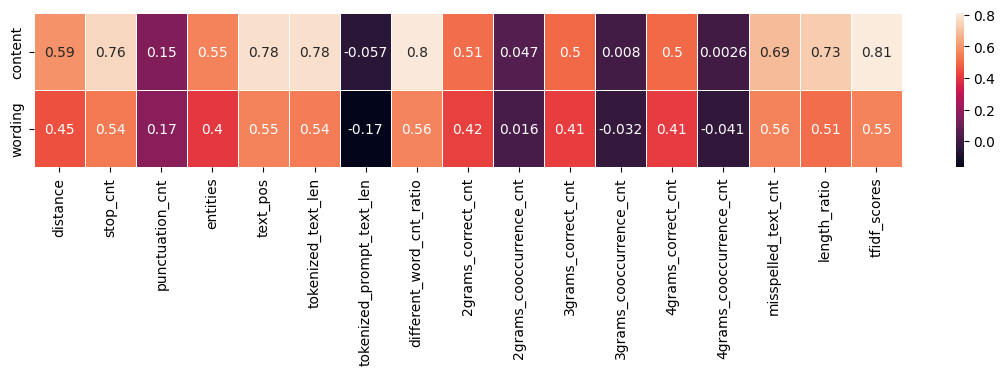

In [103]:
import seaborn as sn
import matplotlib.pyplot as plt
x_labels = content_corr.axes[0].tolist()
y_labels = ['content', 'wording']
fig, ax = plt.subplots(figsize=(14,2))
ax = sn.heatmap([content_corr[2:], wording_corr[2:]], xticklabels=x_labels[2:], yticklabels=y_labels, annot=True, linewidths=.5)
plt.show()

In [104]:
training_data.to_csv('dataset.csv', index=False)

In [105]:
!zip -r 'dataset.zip' 'dataset.csv' # download and save in github

updating: dataset.csv (deflated 95%)
